## Image Classification on CIFAR-10
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. Make sure that you are familiar with torch `Tensor`s, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`), ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

We will use Colab because it has free GPU runtimes available; GPUs can accelerate training times for this problem by 10-100x. **You will need to enable the GPU runtime to use it**. To do so, click "Runtime" above and then "Change runtime type". There under hardware accelerator choose "GPU".

This notebook provides some starter code for the CIFAR-10 problem on HW4, including a completed training loop to assist with some of the Pytorch setup. You'll need to modify this code to implement the layers required for the assignment, but this provides a working training loop to start from.

*Note: GPU runtimes are limited on Colab. Limit your training to short-running jobs (around 20mins or less) and spread training out over time, if possible. Colab WILL limit your usage of GPU time, so plan ahead and be prepared to take breaks during training.* We also suggest performing your early coding/sweeps on a small fraction of the dataset (~10%) to minimize training time and GPU usage.

In [2]:
import torch
from torch import nn
import numpy as np

from typing import Tuple, Union, List, Callable
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline 

C:\Users\Maranatha\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Let's verify that we are using a gpu:

In [3]:
assert torch.cuda.is_available(), "GPU is not available, check the directions above (or disable this assertion to use CPU)"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

cuda


To use the GPU you will need to send both the model and data to a device; this transfers the model from its default location on CPU to the GPU.

Note that torch operations on Tensors will fail if they are not located on the same device.

```python
model = model.to(DEVICE)  # Sending a model to GPU

for x, y in tqdm(data_loader):
  x, y = x.to(DEVICE), y.to(DEVICE)
```
When reading tensors you may need to send them back to cpu, you can do so with `x = x.cpu()`.

Let's load CIFAR-10 data. This is how we load datasets using PyTorch in the real world!

In [4]:
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Here, we'll use the torch `DataLoader` to wrap our datasets. `DataLoader`s handle batching, shuffling, and iterating over data; they can also be useful for building more complex input pipelines that perform transfoermations such as data augmentation.

In [5]:
batch_size = 128

train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

## For Reference: Logistic Regression

This problem is about deep learning architectures, not pytorch. We are providing an implementation of logistic regression using SGD in torch, which can serve as a template for the rest of your implementation in this problem.

Before we get started, let's take a look at our data to get an understanding of what we are doing. CIFAR-10 is a dataset containing images split into 10 classes.

A single batch of images has shape: torch.Size([128, 3, 32, 32])
A single RGB image has 3 channels, width 32, and height 32.
Size of a batch of images flattened with view: torch.Size([128, 3072])
Size of a batch of images flattened with flatten: torch.Size([128, 3072])
True
This image is labeled as class automobile


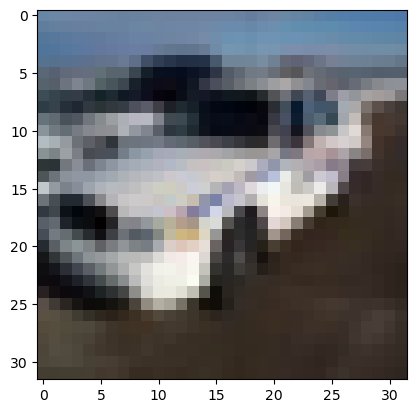

In [6]:
imgs, labels = next(iter(train_loader))
print(f"A single batch of images has shape: {imgs.size()}")
example_image, example_label = imgs[0], labels[0]
c, w, h = example_image.size()
print(f"A single RGB image has {c} channels, width {w}, and height {h}.")

# This is one way to flatten our images
batch_flat_view = imgs.view(-1, c * w * h)
print(f"Size of a batch of images flattened with view: {batch_flat_view.size()}")

# This is another equivalent way
batch_flat_flatten = imgs.flatten(1)
print(f"Size of a batch of images flattened with flatten: {batch_flat_flatten.size()}")

# The new dimension is just the product of the ones we flattened
d = example_image.flatten().size()[0]
print(c * w * h == d)

# View the image
t =  torchvision.transforms.ToPILImage()
plt.imshow(t(example_image))

# These are what the class labels in CIFAR-10 represent. For more information,
# visit https://www.cs.toronto.edu/~kriz/cifar.html
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
           "horse", "ship", "truck"]
print(f"This image is labeled as class {classes[example_label]}")


In this problem, we will attempt to predict what class an image is labeled as.

First, let's create our model. For a linear model we could flatten the data before passing it into the model, but that is not be the case for the convolutional neural network.

In [31]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels=3, out_channels=200, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=6, stride=6)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(5000, 10)
        
    def forward(self, inputs):
        x = self.conv(inputs)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        return self.linear(x)

Let's define a method to train this model using SGD as our optimizer.

In [25]:
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
    )-> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Trains a model for the specified number of epochs using the loaders.

    Returns: 
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
    """

    loss = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        # Main training loop; iterate over train_loader. The loop
        # terminates when the train loader finishes iterating, which is one epoch.
        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss = train_loss + batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc = train_acc + batch_acc.item()

            batch_loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        # Validation loop; use .no_grad() context manager to save memory.
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss = val_loss + v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc = val_acc + batch_acc.item()
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))

    return train_losses, train_accuracies, val_losses, val_accuracies


For this problem, we will be using SGD. The two hyperparameters for our linear model trained with SGD are the learning rate and momentum. Only learning rate will be searched for in this example.

Note: We ask you to plot the accuracies for the best 5 models for each structure, so you will need to return multiple sets of hyperparameters for the homework, or, if you do random search, run your hyperparameter search multiple times.

In [37]:
def parameter_search(train_loader: DataLoader, 
                     val_loader: DataLoader, 
                     model_fn:Callable[[], nn.Module]) -> float:
    """
    Parameter search for our linear model using SGD.

    Args:
    train_loader: the train dataloader.
    val_loader: the validation dataloader.
    model_fn: a function that, when called, returns a torch.nn.Module.

    Returns:
    The learning rate with the least validation loss.
    NOTE: you may need to modify this function to search over and return
     other parameters beyond learning rate.
    """
    num_iter = 50  # This will likely not be enough for the rest of the problem.
    best_loss = torch.tensor(np.inf)
    best_lr = 0.0

    lrs = torch.logspace(-0.9, -1.7, steps=num_iter, base=10)
    
    i = 0
    for lr in lrs:
        i += 1
        print(f"{i}: trying learning rate {lr}")
        model = model_fn().to(DEVICE)
        optim = SGD(model.parameters(), lr, momentum=0.9)
        train_loss, train_acc, val_loss, val_acc = train(
            model,
            optim,
            train_loader,
            val_loader,
            epochs=5
            )

        if min(val_loss) < best_loss:
            best_loss = min(val_loss)
            best_lr = lr
        
    return best_lr

Now that we have everything, we can train and evaluate our model.

In [38]:
best_lr = parameter_search(train_loader, val_loader, ConvNet)

tensor([0.1259, 0.1212, 0.1168, 0.1125, 0.1083, 0.1043, 0.1005, 0.0968, 0.0932,
        0.0898, 0.0864, 0.0833, 0.0802, 0.0772, 0.0744, 0.0716, 0.0690, 0.0664,
        0.0640, 0.0616, 0.0594, 0.0572, 0.0551, 0.0530, 0.0511, 0.0492, 0.0474,
        0.0456, 0.0439, 0.0423, 0.0408, 0.0393, 0.0378, 0.0364, 0.0351, 0.0338,
        0.0325, 0.0313, 0.0302, 0.0291, 0.0280, 0.0270, 0.0260, 0.0250, 0.0241,
        0.0232, 0.0223, 0.0215, 0.0207, 0.0200])
1: trying learning rate 0.1258925497531891


  0%|          | 0/5 [00:00<?, ?it/s]

2: trying learning rate 0.12124769389629364


  0%|          | 0/5 [00:00<?, ?it/s]

3: trying learning rate 0.11677421629428864


  0%|          | 0/5 [00:00<?, ?it/s]

4: trying learning rate 0.11246578395366669


  0%|          | 0/5 [00:00<?, ?it/s]

5: trying learning rate 0.1083163172006607


  0%|          | 0/5 [00:00<?, ?it/s]

6: trying learning rate 0.10431994497776031


  0%|          | 0/5 [00:00<?, ?it/s]

7: trying learning rate 0.10047102719545364


  0%|          | 0/5 [00:00<?, ?it/s]

8: trying learning rate 0.09676411002874374


  0%|          | 0/5 [00:00<?, ?it/s]

9: trying learning rate 0.09319396317005157


  0%|          | 0/5 [00:00<?, ?it/s]

10: trying learning rate 0.08975553512573242


  0%|          | 0/5 [00:00<?, ?it/s]

11: trying learning rate 0.08644396811723709


  0%|          | 0/5 [00:00<?, ?it/s]

12: trying learning rate 0.08325459063053131


  0%|          | 0/5 [00:00<?, ?it/s]

13: trying learning rate 0.08018288016319275


  0%|          | 0/5 [00:00<?, ?it/s]

14: trying learning rate 0.077224500477314


  0%|          | 0/5 [00:00<?, ?it/s]

15: trying learning rate 0.07437527179718018


  0%|          | 0/5 [00:00<?, ?it/s]

16: trying learning rate 0.07163117080926895


  0%|          | 0/5 [00:00<?, ?it/s]

17: trying learning rate 0.06898830831050873


  0%|          | 0/5 [00:00<?, ?it/s]

18: trying learning rate 0.06644295901060104


  0%|          | 0/5 [00:00<?, ?it/s]

19: trying learning rate 0.06399152427911758


  0%|          | 0/5 [00:00<?, ?it/s]

20: trying learning rate 0.06163053214550018


  0%|          | 0/5 [00:00<?, ?it/s]

21: trying learning rate 0.05935664847493172


  0%|          | 0/5 [00:00<?, ?it/s]

22: trying learning rate 0.05716666579246521


  0%|          | 0/5 [00:00<?, ?it/s]

23: trying learning rate 0.055057477205991745


  0%|          | 0/5 [00:00<?, ?it/s]

24: trying learning rate 0.05302611365914345


  0%|          | 0/5 [00:00<?, ?it/s]

25: trying learning rate 0.05106969550251961


  0%|          | 0/5 [00:00<?, ?it/s]

26: trying learning rate 0.049185458570718765


  0%|          | 0/5 [00:00<?, ?it/s]

27: trying learning rate 0.04737074300646782


  0%|          | 0/5 [00:00<?, ?it/s]

28: trying learning rate 0.04562298208475113


  0%|          | 0/5 [00:00<?, ?it/s]

29: trying learning rate 0.043939702212810516


  0%|          | 0/5 [00:00<?, ?it/s]

30: trying learning rate 0.04231853038072586


  0%|          | 0/5 [00:00<?, ?it/s]

31: trying learning rate 0.04075717553496361


  0%|          | 0/5 [00:00<?, ?it/s]

32: trying learning rate 0.03925342112779617


  0%|          | 0/5 [00:00<?, ?it/s]

33: trying learning rate 0.03780515119433403


  0%|          | 0/5 [00:00<?, ?it/s]

34: trying learning rate 0.036410316824913025


  0%|          | 0/5 [00:00<?, ?it/s]

35: trying learning rate 0.03506694361567497


  0%|          | 0/5 [00:00<?, ?it/s]

36: trying learning rate 0.033773135393857956


  0%|          | 0/5 [00:00<?, ?it/s]

37: trying learning rate 0.03252706304192543


  0%|          | 0/5 [00:00<?, ?it/s]

38: trying learning rate 0.03132696449756622


  0%|          | 0/5 [00:00<?, ?it/s]

39: trying learning rate 0.030171146616339684


  0%|          | 0/5 [00:00<?, ?it/s]

40: trying learning rate 0.029057970270514488


  0%|          | 0/5 [00:00<?, ?it/s]

41: trying learning rate 0.027985865250229836


  0%|          | 0/5 [00:00<?, ?it/s]

42: trying learning rate 0.0269533172249794


  0%|          | 0/5 [00:00<?, ?it/s]

43: trying learning rate 0.025958864018321037


  0%|          | 0/5 [00:00<?, ?it/s]

44: trying learning rate 0.025001101195812225


  0%|          | 0/5 [00:00<?, ?it/s]

45: trying learning rate 0.024078676477074623


  0%|          | 0/5 [00:00<?, ?it/s]

46: trying learning rate 0.02319028414785862


  0%|          | 0/5 [00:00<?, ?it/s]

47: trying learning rate 0.022334670647978783


  0%|          | 0/5 [00:00<?, ?it/s]

48: trying learning rate 0.021510625258088112


  0%|          | 0/5 [00:00<?, ?it/s]

49: trying learning rate 0.02071698196232319


  0%|          | 0/5 [00:00<?, ?it/s]

50: trying learning rate 0.019952621310949326


  0%|          | 0/5 [00:00<?, ?it/s]

In [40]:
model = ConvNet().to(DEVICE)
optimizer = SGD(model.parameters(), best_lr, momentum=0.9)

In [42]:
print("LR: ", best_lr)
train_loss, train_accuracy, val_loss, val_accuracy = train(
    model, optimizer, train_loader, val_loader, 50)

LR:  tensor(0.0393)


  0%|          | 0/50 [00:00<?, ?it/s]

Plot the training and validation accuracy for each epoch.

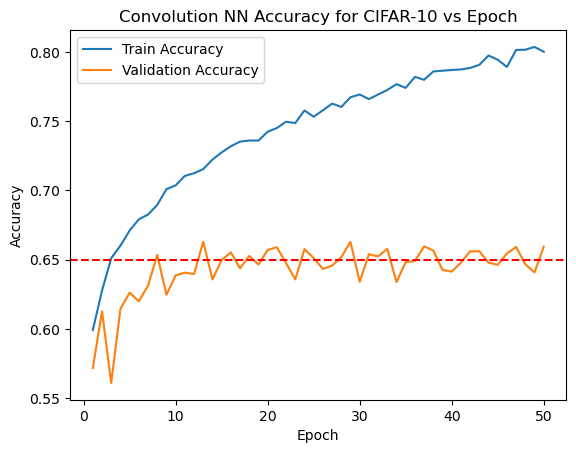

In [43]:
epochs = range(1, 51)
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.axhline(y=0.65, color='r', linestyle='--')
plt.legend()
plt.title("Convolution NN Accuracy for CIFAR-10 vs Epoch")
plt.savefig('conv_net_plot.png')
plt.show()

The last thing we have to do is evaluate our model on the testing data.

In [44]:
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
    """Computes test loss and accuracy of model on loader."""
    loss = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for (batch, labels) in loader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            y_batch_pred = model(batch)
            batch_loss = loss(y_batch_pred, labels)
            test_loss = test_loss + batch_loss.item()

            pred_max = torch.argmax(y_batch_pred, 1)
            batch_acc = torch.sum(pred_max == labels)
            test_acc = test_acc + batch_acc.item()
        test_loss = test_loss / len(loader)
        test_acc = test_acc / (batch_size * len(loader))
        return test_loss, test_acc

In [45]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.6644580696202531


The rest is yours to code. You can structure the code any way you would like.

We do advise making using code cells and functions (train, search, predict etc.) for each subproblem, since they will make your code easier to debug. 

Also note that several of the functions above can be reused for the various different models you will implement for this problem; i.e., you won't need to write a new `evaluate()`.